In [26]:
using Pkg;Pkg.update(); for p in ("Embeddings","DataFrames","DataStructures","DataFrames","FileIO","LinearAlgebra","Knet","FileIO"); haskey(Pkg.installed(),p) || Pkg.add(p); end
using DataStructures,DataFrames,FileIO,Embeddings,LinearAlgebra,DataFrames;
using Base.Iterators: flatten
using Statistics: mean
using Knet: Knet, conv4, pool, mat, KnetArray, nll, zeroone, progress, sgd, param, param0, dropout, relu, Data,minibatch;
using Dates

  Updating registry at `~/.julia/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`
Fetching: [========================================>]  100.0 %.0 % [==========>                              ]  24.1 %]  47.9 % [=============================>           ]  72.0 %> ]  95.8 % Resolving package versions...
 Installed TranscodingStreams ─ v0.9.4
 Installed GR ───────────────── v0.39.1
  Updating `~/.julia/environments/v1.1/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.1/Manifest.toml`
  [28b8d3ca] ↑ GR v0.39.0 ⇒ v0.39.1
  [3bb67fe8] ↑ TranscodingStreams v0.9.3 ⇒ v0.9.4
  Building GR → `~/.julia/packages/GR/KGODl/deps/build.log`


In [27]:
labels=["abbreviation", "entity", "description", "location" ,"numeric"," "]
revs, W, W2, word_idx_map, vocab=load("Data/TREC_sib.jld2","datas"); 
word_idx_map["ROOT"]=size(W,1);
W=W';

In [28]:
#Transforms sentence into a list of indices. Pad with zeroes.
function get_text_mat(t,word_idx_map;max_l=56,filter_h=5)
    #t the text of question
    x=[] # output matrix
    pad=filter_h -1 # padding number
    for i in collect(1:pad);push!(x,0);end #adding padding 
    words=split(t)
    #extract the unique id of words in the question text and adding it to the matrix 
    for w in words
        if w in keys(word_idx_map);push!(x,word_idx_map[w])
        else; @show w ;end
    end    

    while length(x)<max_l+2*pad    # accomplish 64 +1 size by adding zeros till finish 
            push!(x,0)
    end
    
    return  x
end

get_text_mat (generic function with 1 method)

In [29]:
function getSen(vector)
#labels=["abbreviation","numeric",  "description", "human","location" ,"entity"]
t=Array{Int}(vector)
println(permutedims(t))
for i in t
    if i==1557;print("?\n y =",t[end]+1 );break;end
    if i==0;continue;end
    for (key,value) in word_idx_map
        if value==i; print(key," ");end
    end
end
end

getSen (generic function with 1 method)

In [30]:
#Transforms sentence into a list of indices. Pad with zeroes. 
function get_tree_rep(r,word_idx_map)
# question 
#@show t=r["tree"] #the tree of question
    each_sent=deepcopy(r)# output matrix
    for (j, each_word) in enumerate(each_sent[1:end-1])
        #@show (j, each_word)
            for (l, each_field) in enumerate(each_word)
           # @show (l, each_field)
                if each_field in keys( word_idx_map)
                #@show j,l ;
                    each_sent[j]=Array{Any,1}(each_sent[j])
                     each_sent[j][l] = word_idx_map[each_field]
                elseif each_field == 0
                    continue
                else
                    @show each_field
                end
            end
    end       
    return each_sent;
end

get_tree_rep (generic function with 1 method)

In [31]:
#merage each sentecne's words trees(sibling+ancators) together
sent1=vcat([permutedims(vcat(datasetTensor[1][x][1:end-1]...)) for x in 1:size(datasetTensor[1],1)]);#sent1=vcat([permutedims(vcat(datasetTensor[1][1][1:end-1]...)) for x in 1:size(datasetTensor[1],1)]...)
sent2=vcat([permutedims(vcat(datasetTensor[2][x][1:end-1]...)) for x in 1:size(datasetTensor[2],1)]);#sent1=vcat([permutedims(vcat(datasetTensor[1][1][1:end-1]...)) for x in 1:size(datasetTensor[1],1)]...);
#sent1=vcat([permutedims(vcat(datasetTensor[1][1][1:end-1]...)) for x in 1:size(datasetTensor[1],1)]...)'
size(sent1)

(5451,)

In [32]:
#get y 
y_train=Array{Int8}([dataset[1][:,x][end] for x in 1:size(dataset[1],2)]);#ytrainT=[datasetTensor[1][x,:][end][end][end] for x in 1:size(datasetTensor[1],1)];
y_test=Array{Int8}([dataset[2][:,x][end] for x in 1:size(dataset[2],2)]);#ytestT=[datasetTensor[2][x,:][end][end][end] for x in 1:size(datasetTensor[2],1)];

y_train=y_train.+1;
y_test=y_test.+1;



In [33]:
#minibatching
dtrn=minibatch(sent1,y_train,160,shuffle=true);
dtst=minibatch(sent2,y_test,160);
#summary.(Iterators.first(dtrn))
# (x,y) = first(dtrn)
# println.(summary.(x));
summary.(Iterators.first(dtrn))

("160-element Array{Array{Any,2},1}", "160-element Array{Int64,1}")

In [34]:
# Define a convolutional layer:
struct Conv; w; b; f; p;E; end
function (c::Conv)(x) 
#     println("\nConvdeyim \t", typeof(x),"\t", summary(x) )
    #xx=KnetArray{Float32}(reshape(c.E[:, permutedims(hcat(x...))],(300,450,1,160)))
    return c.f.(pool(conv4(c.w, dropout(x,c.p)) .+ c.b))
end
Conv(w1::Int,w2::Int,cx::Int,cy::Int,f=relu;pdrop=0,E=W) = Conv(param(w1,w2,cx,cy), param0(1,1,cy,1), f, pdrop,E)

Conv

In [35]:
# Redefine dense layer (See mlp.ipynb):
struct Dense; w; b; f; p; end
function (d::Dense)(x) 
#     println("\nDensedeyim ,\t " , typeof(x),"\t", summary(x))
    d.f.(d.w * mat(dropout(x,d.p)) .+ d.b) # mat reshapes 4-D tensor to 2-D matrix so we can use matmul
end
Dense(i::Int,o::Int,f=relu;pdrop=0) = Dense(param(o,i), param0(o), f, pdrop)

Dense

In [36]:
# Let's define a chain of layers

struct Chain
    layers
    Chain(layers...) = new(layers)
end
function (c::Chain)(x)
    #println(Dates.format(now(), "MM:SS"),".Chaindeyim\t",summary(x),"\t",size(x))
    x=KnetArray{Float32}(reshape(W[:, permutedims(hcat(x...))],(300,450,1,160)))
    #println(Dates.format(now(), "MM:SS"),".Chaindeyim\t",summary(x),"\t",size(x))
#     println("\nChaindeyim ,\t ", typeof(x),"\t", summary(x))
    (for l in c.layers; x = l(x); end; x)
end
function (c::Chain)(x,y) 
#     println("\nloss Chaindeyim x ,\t ", typeof(x),"\t", summary(x))
#     println("\nloss Chaindeyim y ,\t ", typeof(y),"\t", summary(y))
    nll(c(x),y)
    
end
(c::Chain)(d::Data) = mean(c(x,y) for (x,y) in d)

In [37]:
n_epochs=50;
lr_decay = 0.95
function trainresults(file,model; o...)
        println("lr =",lr_decay," \t n_epochs= ",n_epochs)
    if (print("Train from scratch? "); readline()[1]=='y')
        takeevery(n,itr) = (x for (i,x) in enumerate(itr) if i % n == 1)
        r = ((model(dtrn), model(dtst), zeroone(model,dtrn), zeroone(model,dtst))
             for x in takeevery(length(dtrn), progress(sgd(model,repeat(dtrn,n_epochs),lr=lr_decay))))
        r = reshape(collect(Float32,flatten(r)),(4,:))
        Knet.save(file,"results",r)
        Knet.gc() # To save gpu memory
    else
        if isfile(file);r=Knet.load(file,"results");else;println("there is no file such this");return;end
    end
    println(minimum(r,dims=2))
    return r
end

trainresults (generic function with 1 method)

In [38]:
using Plots; default(fmt=:png,ls=:auto)

In [39]:
#cnn9 with 500 epo
cnn13=Knet.load("models/dcnn8.jld2","results");

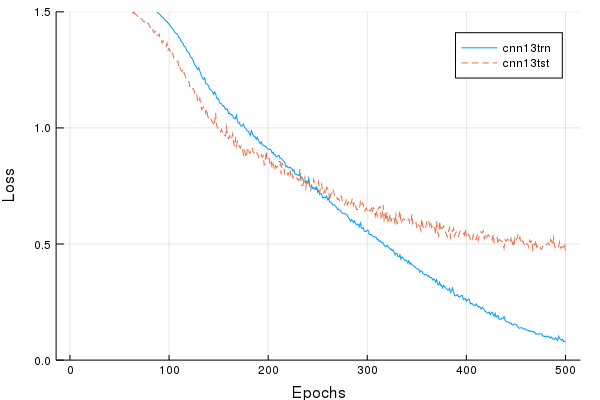

In [40]:
plot([cnn13[1,:],cnn13[2,:]],ylim=(0.0,1.5),
     labels=[:cnn13trn :cnn13tst],xlabel="Epochs",ylabel="Loss")

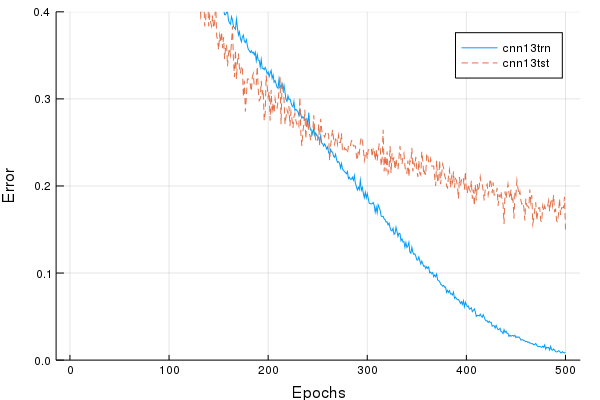

In [41]:
plot([cnn13[3,:],cnn13[4,:]],ylim=(0.0,0.4),
    labels=[:cnn13trn :cnn13tst],xlabel="Epochs",ylabel="Error")  

In [42]:
cnn14=Knet.load("models/dcnn8_2.jld2","results");
#cnn13 with epoch 650

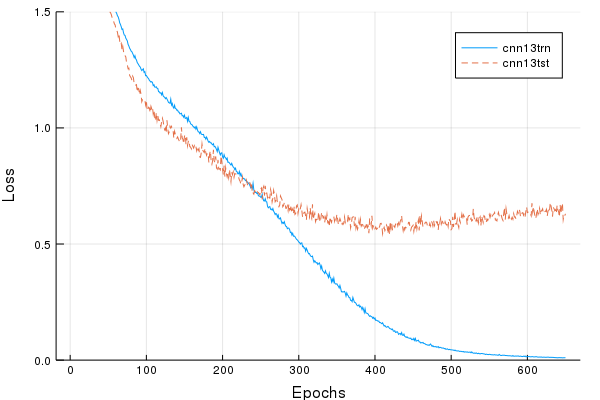

In [43]:
plot([cnn14[1,:],cnn14[2,:]],ylim=(0.0,1.5),
     labels=[:cnn13trn :cnn13tst],xlabel="Epochs",ylabel="Loss")

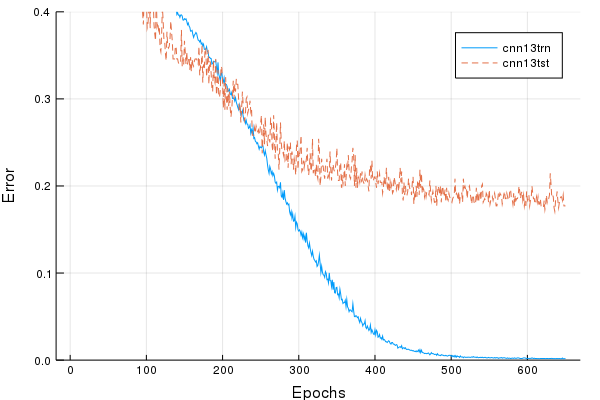

In [44]:
plot([cnn14[3,:],cnn14[4,:]],ylim=(0.0,0.4),
    labels=[:cnn13trn :cnn13tst],xlabel="Epochs",ylabel="Error")  

In [45]:
cnn15=Knet.load("models/dcnn8_3.jld2","results");
#cnn13 with epoch 650 - lr= 0,0075

In [ ]:
plot([cnn14[1,:],cnn14[2,:]],ylim=(0.0,1.5),
     labels=[:cnn13trn :cnn13tst],xlabel="Epochs",ylabel="Loss")